# Table of Contents

- Setup 
    - Dataset and DataLoader
    - Training loop
    - Model architecture
- Model Training
- Model Testing
- General CNN Notes

## Setup

In [1]:
import torch
from torch import tensor, Tensor
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'{device.type = }')

device.type = 'cpu'


### Dataset and DataLoader

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

cifar = datasets.CIFAR10('./data', train=True, download=True, transform=transform)

Files already downloaded and verified


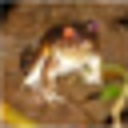

ex_label_idx = 6, idx_to_label[ex_label_idx] = 'frog' 

ex_img.shape = torch.Size([3, 32, 32])
ex_img.numel() = 3072


In [4]:
def display_tensor_as_image(tensor: Tensor):
    '''
    Display a tensor of shape (3, 32, 32) as a (3, 32, 32) image.
    '''
    tensor = tensor.view(3, 32, 32)

    to_img = transforms.ToPILImage()
    img: Image.Image = to_img(tensor)

    img = img.resize((32*4, 32*4))
    display(img)


idx_to_label = {
    idx: label
    for label, idx
    in cifar.class_to_idx.items()
}

ex_img, ex_label_idx = cifar[0]
display_tensor_as_image(ex_img)
print(f'{ex_label_idx = }, {idx_to_label[ex_label_idx] = }', '\n')
print(f'{ex_img.shape = }')
print(f'{ex_img.numel() = }')

In [5]:
n = 5000

first_n_items = [cifar[i] for i in range(n)]
first_n_labels = [idx_to_label[idx]
                    for _, idx
                    in first_n_items]

first_n_value_counts = pd.Series(first_n_labels).value_counts()

(
    pd.DataFrame(
        data={
            f'first_{n}_value_counts': first_n_value_counts,
        }
    )
)


,first_5000_value_counts
ship,520
frog,519
bird,519
deer,519
airplane,505
truck,498
dog,488
horse,486
cat,486
automobile,460


The first 5,000 items are close enough to balanced that I'm ok using them as the validation set. A validation set of 5,000 represents 10% of the training dataset

In [6]:
cifar_validation = [cifar[i] for i in range(0, n)]
cifar_train = [cifar[i] for i in range(n, len(cifar))]

assert len(cifar_validation) + len(cifar_train) == len(cifar)

cifar_validation_loader = DataLoader(dataset=cifar_validation, batch_size=64, shuffle=True)

### Data Augmentation

I want to extend the training data to force the model to learn more robust representations of the images by doubling the training dataset size and variety by flipping all images horizontally

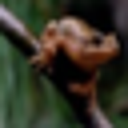

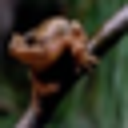

In [7]:
display_tensor_as_image(cifar_train[0][0])
display_tensor_as_image(torch.flip(cifar_train[0][0], dims=[2]))

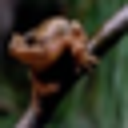

len(cifar_train) = 90000


In [8]:
cifar_train_flipped = [(torch.flip(img, dims=[2]), label) for img, label in cifar_train]
display_tensor_as_image(cifar_train_flipped[0][0])

cifar_train.extend(cifar_train_flipped)
print(f'{len(cifar_train) = }')
cifar_train_loader = DataLoader(dataset=cifar_train, batch_size=64, shuffle=True)

### Training Loop

In [9]:
from typing import Callable

def validate_one_epoch(model: nn.Module, validation_dataloader: DataLoader, loss_fn: Callable[[Tensor, Tensor], Tensor]) -> tuple[float, float]:
    '''return the loss and the accuracy of the model on the validation dataloader'''
    model.eval()

    epoch_running_loss = 0
    total_samples = 0
    correct = 0

    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)

            # calculate loss
            loss = loss_fn(logits, labels)
            epoch_running_loss += loss.item()

            # caluclate accuracy
            _, predictions = torch.max(logits, 1)
            correct += (predictions == labels).sum().item()
            total_samples += len(inputs)

    epoch_avg_loss = epoch_running_loss / len(validation_dataloader)
    accuracy = correct / total_samples
    
    return epoch_avg_loss, accuracy


def train_one_epoch(model: nn.Module, dataloader: DataLoader, loss_fn: Callable[[Tensor, Tensor], Tensor], optimizer: torch.optim.Optimizer) -> float:
    '''train the model for one epoch. return the average loss of the epoch'''
    model.train()

    epoch_running_loss = 0

    for batch in dataloader:
        inputs, labels = batch

        inputs = inputs.to(device) #  move to GPU if available
        labels = labels.to(device) #  move to GPU if available

        optimizer.zero_grad() # zero gradients

        predictions = model(inputs)

        # compute loss and propogate gradients
        loss = loss_fn(predictions, labels)
        loss.backward()

        optimizer.step()

        # update metainformation
        epoch_running_loss += loss.item()

    epoch_avg_loss = epoch_running_loss / len(dataloader)
    return epoch_avg_loss


def train_n_epochs(n: int, model: nn.Module, train_dataloader: DataLoader, validation_dataloader: DataLoader, loss_fn: Callable[[Tensor, Tensor], Tensor], optimizer: torch.optim.Optimizer) -> None:
    for i in range(n):
        epoch_train_avg_loss = train_one_epoch(model, train_dataloader, loss_fn, optimizer)
        epoch_validation_avg_loss, epoch_validation_accuracy = validate_one_epoch(model, validation_dataloader, loss_fn)
        print(f'EPOCH {i}:') 
        print(f'train - epoch avg loss: {epoch_train_avg_loss}')
        print(f'valid - epoch avg loss: {epoch_validation_avg_loss}')
        print(f'valid - epoch accuracy: {epoch_validation_accuracy }')
        print()

### Model Architecture

In [32]:
class CNN(nn.Module):
    '''
    Convolutional Neural Network
    '''
    def __init__(self):
        super(CNN, self).__init__()

        layer_0_n_filters = 8
        layer_1_n_filters = 32

        # type self.features: (batch, 3, 32, 32) => (batch, layer_1_n_filters, 16, 16)
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=layer_0_n_filters, kernel_size=3, padding=int((3 - 1) / 2)),
            nn.ReLU(),
            nn.Conv2d(in_channels=layer_0_n_filters, out_channels=layer_1_n_filters, kernel_size=3, padding=int((3 - 1) / 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # downsample
        )

        # type self.classify: (batch, layer_1_n_filters, 16, 16) => (batch, 10)
        self.classify = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(layer_1_n_filters*16*16, 16*16),
            nn.ReLU(),
            nn.Linear(16*16, 10)
        )


    def forward(self, x):
        x = self.features(x)
        x = self.classify(x)
        return x


---
## Model Training

In [33]:
cnn = CNN()
cnn.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr=.001, params=cnn.parameters())

In [34]:
n_epochs = 10
train_n_epochs(n_epochs, cnn, cifar_train_loader, cifar_validation_loader, loss_fn, optimizer)

EPOCH 0:
train - epoch avg loss: 1.3492425080725041
valid - epoch avg loss: 1.1130486062810392
valid - epoch accuracy: 0.598

EPOCH 1:
train - epoch avg loss: 0.9851394356271436
valid - epoch avg loss: 0.942269175113002
valid - epoch accuracy: 0.6738

EPOCH 2:
train - epoch avg loss: 0.8165012129503696
valid - epoch avg loss: 0.8934724444075476
valid - epoch accuracy: 0.6978

EPOCH 3:
train - epoch avg loss: 0.689756265920193
valid - epoch avg loss: 0.8963997462127782
valid - epoch accuracy: 0.6918

EPOCH 4:
train - epoch avg loss: 0.5716738376366644
valid - epoch avg loss: 0.896726373630234
valid - epoch accuracy: 0.7082

EPOCH 5:
train - epoch avg loss: 0.4635635595967266
valid - epoch avg loss: 0.8957783296892915
valid - epoch accuracy: 0.7144

EPOCH 6:
train - epoch avg loss: 0.3591768039547982
valid - epoch avg loss: 0.9964712571494186
valid - epoch accuracy: 0.7114

EPOCH 7:
train - epoch avg loss: 0.2663837889290144
valid - epoch avg loss: 1.1618884726415706
valid - epoch accura

---
## Model Testing

In [36]:
cifar_test = datasets.CIFAR10('./data', train=False, download=True, transform=transform)
cifar_test_loader = DataLoader(dataset=cifar_test, batch_size=64, shuffle=True)

Files already downloaded and verified


In [37]:
cnn.eval()

correct = 0
total = 0

all_predictions = []

with torch.no_grad():
    for inputs, labels in cifar_test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = cnn(inputs)

        _, predictions = torch.max(logits, 1)

        # predictions.shape = [64]
        # labels.shape = [64]

        all_predictions.append(predictions)

        total += len(inputs)
        correct += (predictions == labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the cnn on the CIFAR-10 test images: {accuracy * 100}%')

Accuracy of the cnn on the CIFAR-10 test images: 69.06%


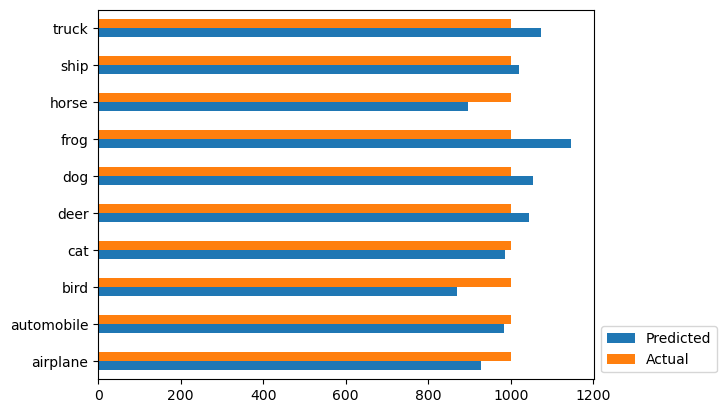

In [38]:
predicted_value_counts = pd.Series(torch.cat(all_predictions)).value_counts()
actual_value_counts = pd.Series(torch.cat([labels for inputs, labels in cifar_test_loader])).value_counts()

for series in [predicted_value_counts, actual_value_counts]:
    series.index = [idx_to_label[idx] for idx in series.index]

df = (
    pd.DataFrame(
        data={
            'Predicted': predicted_value_counts,
            'Actual': actual_value_counts
        }
    )
)


df.plot.barh()
plt.legend(loc = 3, bbox_to_anchor=(1,0))

plt.show()

In [39]:
cnn

CNN(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classify): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

### Model 0 - Baseline
```python
CNN(
  (conv_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected_1): Sequential(
    (0): Linear(in_features=2560, out_features=100, bias=True)
    (1): ReLU()
  )
  (fully_connected_2): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
  )
)

# num parameters
sum(p.numel() for p in cnn.parameters() if p.requires_grad) # => 257390 parameters
```

#### First attempt

- after 20 epcohs: 61.08% accuracy
- after 30 epochs: 58.81% accuracy
- after 40 epochs: 57.93% accuracy

it is obviously overfitting.

#### Second attempt

##### Changes

- augmented training dataset by flipping all images horizontally. (increased dataset size by 2)

##### Performance

```
EPOCH 5:
train - epoch avg loss: 0.761481237585187
valid - epoch avg loss: 1.0753993060015425
valid - epoch accuracy: 0.64
```

The more it trained, the more it became apparent that it began to overfit. After training 25 epochs (and overfitting), it got 61.8% accuracy on the test images

#### Third attempt

##### Changes

### Model 1 
```python
CNN(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classify): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

# type self.features: (batch, 3, 32, 32) => (batch, layer_1_n_filters, 16, 16)
# type self.classify: (batch, layer_1_n_filters, 16, 16) => (batch, 10)
```

#### First training attempt
```
START
EPOCH 0:
train - epoch avg loss: 1.3492425080725041
valid - epoch avg loss: 1.1130486062810392
valid - epoch accuracy: 0.598


BEST
EPOCH 5:
train - epoch avg loss: 0.4635635595967266
valid - epoch avg loss: 0.8957783296892915
valid - epoch accuracy: 0.7144

WORST
EPOCH 9:
train - epoch avg loss: 0.14566150779737252
valid - epoch avg loss: 1.4388105092169363
valid - epoch accuracy: 0.6984
```

The model's very low loss on the training data but decreasing accuracy on the validation shows that it is severely overfitting.

- [ ] TODO: add dropout

---

## General CNN Notes

### What is the kernel doing with 3 channels?

In [40]:
torch.manual_seed(3)

kernel = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, padding=1, stride=1)
print(f'{kernel.weight.shape = }', '\n')

input_data = torch.ones(3, 5, 5)
print(f'{input_data.shape = }', '\n')

kernel.weight.shape = torch.Size([1, 3, 3, 3]) 

input_data.shape = torch.Size([3, 5, 5]) 



In [41]:
feature_map = kernel(input_data)
print(f'{feature_map.shape = }')

feature_map.shape = torch.Size([1, 5, 5])


In [42]:
feature_map_top_left_value = feature_map[0][0][0]
feature_map_top_left_value

tensor(-0.3880, grad_fn=<SelectBackward0>)

-0.3880 is the actual output value at the top left of the feature map (aka the value from the top left corner of the input data). I want to calculate this manually to verify the calculation works like I expect 

In [43]:
import torch.nn.functional as F

first_chunk_of_input = input_data[:, :2, :2]

# pad tuple: (left, right, top, bottom)
first_chunk_of_input = F.pad(first_chunk_of_input, (1, 0, 1, 0), 'constant', 0)

first_chunk_of_input, first_chunk_of_input.shape

(tensor([[[0., 0., 0.],
          [0., 1., 1.],
          [0., 1., 1.]],
 
         [[0., 0., 0.],
          [0., 1., 1.],
          [0., 1., 1.]],
 
         [[0., 0., 0.],
          [0., 1., 1.],
          [0., 1., 1.]]]),
 torch.Size([3, 3, 3]))

#### Thinking of the problem with dot products

This is an alternative view point (compared to element wise multiplication and then sums), which gives better insight into the fact that the kernel is capturing the similarity between the channels of the input data and the kernel's layers. The convolution operation is a channel wise operation of computing dot products with a sliding window.

In [45]:
num_channels = 3
kernel_layer_outputs = [torch.dot(kernel.weight[0][i].flatten(), first_chunk_of_input[i].flatten()) for i in range(num_channels)]
sum(kernel_layer_outputs) + kernel.bias

tensor([-0.3880], grad_fn=<AddBackward0>)